# Gene-Prediction-in-Metagenomics-Fragments
Written by: Vignesh Ravindranath, Shawn Huang

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The purpose of the project is to gain a `deeper understanding of machine learning approaches behind the Orphelia gene prediction algorithm`. 
    
The project consists of several sections:
1. Helper Functions (preprocessing, orf-finder, find-interregions)
2. Preprocess Genome (extract coding sequences/non-coding sequences, shuffle/split data)
3. Extract Features (monocodon frequency, dicodon frequency, tis, gc)
3. Linear Discriminant - Dimentionality Reduction on monocodon/dicodon/tis
4. Binary classification neural network for coding/noncoding gene prediction
    
In the second section, high-dimensional features such as `monocodon (tricodon) usage`, `dicodon (hexcodon) usage`, and `translation initiation sites (TIS)` must be extracted from prokaryotic genomes. Monocodon and dicodon usage refer to the frequence of codons (3 basepairs) and dicodons (6 basepairs) in coding and noncoding regions. Coding proteins often have a TIS upstream of the start codon. These TIS patterns are extracted by comparing up and downstream regions for positive TIS candidates (true start codons in coding sequences) to negative TIS candidates (start codons in noncoding sequences).  
    
In the fourth section, linear discriminants are derived to reduce the dimensionality of the extracted features. The individual features (excluding GC content) are taken as multivariate linear regression problems and the Normal Equation is utilized to compute the weights (coefficient) matrix for each feature. 
    
In the last section, a neural network is trained on the reduced features mentioned above, in addition to the `GC content`.

    Summary of features:
    x1 - tricodon       - (n,64) 
    x2 - hexcodon       - (n,4096)
    x3 - TIS-pos        - (n,58,64 == n,3712)
    x4 - TIS-neg        - (n,58,64 == n,3712)
    x7 - GC content     - (n,1) column

In [1]:
import os
import sys
import pickle
import numpy as np
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload

from preprocess import preprocess_genome
from fe import extract_codon_tis_features, LD_tis_training_features, populate_codon_idx_dict
from ld import train_linear_discriminant, prior_gaussian, X3, X4

# https://towardsdatascience.com/jupyter-notebook-best-practices-f430a6ba8c69
# https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html

In [2]:
def save(name, data):
    filename = './data/' + name
    outfile = open(filename, 'wb')
    pickle.dump(data, outfile)
    outfile.close()
    print(f'Saved data to {filename}.')
    
def load(name):
    filename = './data/' + name
    infile = open(filename, 'rb')
    data = pickle.load(infile)
    infile.close()
    print(f'Loaded data from {filename}.')
    return data

# Preprocess Genome - Extract Positive/Negative ORFs

Preprocessing a genome consists of finding all valid open reading frames (ORFs). ORFs start with a start codon (ATG, CTG, GTG, or TGT) and end with an in-frame stop codon (TAG, TGA, or TAA). To train our neural network, we need to find positive ORFs - sequencies that code for a protein (i.e. genes) -  and negative ORFs - sequencies in the genome that start with a start codon and end with an in-frame stop codon, but don't code for a protein. The negative ORFs can be found in the interregions of a genome or space between genes. 

For this project, positive ORFs will be referred to as CDS or CoDing Sequences, and negative ORFs will be referred to as NCS or Negative Coding Sequences.

In [3]:
prokaryote_ids = ['NC_000917','NC_005966']

# preprocess_genome takes an input list of GenBank prokaryote ids
%time _cds, _ncs = preprocess_genome(prokaryote_ids)

print(f'{len(_cds)} CDS Records')
print(f'{len(_ncs)} NCS Records')

Fetched NC_000917 GenBank sequence
Fetched NC_000917 FASTA sequence
Fetched NC_005966 GenBank sequence
Fetched NC_005966 FASTA sequence
CPU times: user 35.4 s, sys: 500 ms, total: 35.9 s
Wall time: 1min 16s
5714 CDS Records
2701 NCS Records
Saved data to ./data/orfs.


In [ ]:
# save data
save('orfs', [_cds, _ncs])

In [4]:
# load data
_cds, _ncs = load('orfs')

print(f'{len(_cds)} CDS ORFs')
print(f'{len(_ncs)} NCS ORFs')

Loaded data from ./data/orfs.
5714 CDS ORFs
2701 NCS ORFs


## Shuffle and Split Data

In [5]:
import random
random.seed(8)
random.shuffle(_cds)
random.shuffle(_ncs)

for i in range(5):
    print(_cds[i].name, _ncs[i].name)

ACIAD_RS00910 AC_NC03044
AF_RS10255 AF_NC01962
ACIAD_RS10630 AC_NC01559
AF_RS10525 AF_NC02446
AF_RS11270 AF_NC01629


In [6]:
a = int(len(_cds)/2)
b = int(len(_ncs)/2)

LD_Tis_Data = _cds[0:a]
LD_Cod_Data = _cds[0:a] + _ncs[0:b]
NN_Data = _cds[a:] + _ncs[b:]

print(f'LD Dataset: {len(LD_Tis_Data)}')
print(f'LD Dataset: {len(LD_Cod_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 2857
LD Dataset: 4207
NN Dataset: 4208


# Extract Codon and TIS Features for LD Training

The neural network won't be taking an entire ORF sequence as an input. Rather, we will first extract important features and train the neural network on those features. Important features include codon frequency (ex. ATGCCC... => 'ATG', 'CCC', ...) and translation initiation sites (tis). For codon frequency we can extract monocodon usage (what are all the codons in the sequence) and dicodon usage (what are all the dicodons in the sequence; ex. ATGCCCTTTGGG... => 'ATGCCC', 'TTTGGG', ...). Tis usually occur upstream of the start codon for a codon sequence (gene). So, for the tis feature, we will extract a frame that looks at 30 basepairs (bp) upstream and downstream of start codons (see heatmap below).

In [7]:
# features: tri, hex, tis_nn, gc, y
%time LD_tri, LD_hex, _, _, LD_yc = extract_codon_tis_features(LD_Cod_Data, train_nn=False)

# tis features: tis, yt
%time LD_tis, LD_yt = LD_tis_training_features(LD_Tis_Data)

# save data
save('LDFE', [LD_tri, LD_hex, LD_yc, LD_tis, LD_yt])

CPU times: user 10.5 s, sys: 328 ms, total: 10.8 s
Wall time: 10.8 s
CPU times: user 9.73 s, sys: 4.83 s, total: 14.6 s
Wall time: 14.6 s
Saved data to ./data/LDFE.


## Train Discriminant Weight Vectors

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

In [8]:
# train weight vectors - csr_matrix (sparse row matrix) is used to speed up calculation/reduce space of data 
%time wM = train_linear_discriminant(csr_matrix(LD_tri), LD_yc) # monocodon (tri)
%time wD = train_linear_discriminant(csr_matrix(LD_hex), LD_yc) # dicodon (hex)
%time wT = train_linear_discriminant(csr_matrix(LD_tis), LD_yt) # tis

print(wM.shape, wD.shape, wT.shape)

CPU times: user 109 ms, sys: 31.2 ms, total: 141 ms
Wall time: 132 ms
CPU times: user 16.9 s, sys: 1.81 s, total: 18.7 s
Wall time: 12.6 s
CPU times: user 22.5 s, sys: 6.12 s, total: 28.6 s
Wall time: 24.3 s
(64,) (4096,) (3712,)
Saved data to ./data/weights.


In [9]:
# save data
save('weights', [wM, wD, wT])

Saved data to ./data/weights.


Loaded data from ./data/weights.


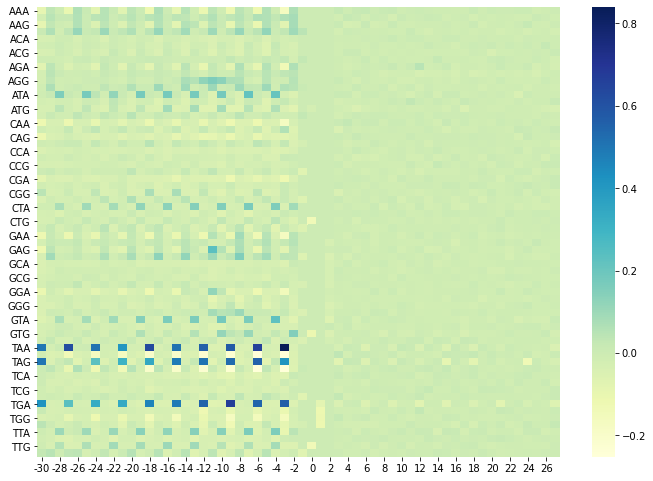

In [4]:
# visualize TIS patterns (up and downstream regions)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

_, _, wT = load('weights')
w = np.array(wT).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict(nbases=3).keys()
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(w, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

## Find Gaussian Distributions for Postive/Negative TIS Features

In [14]:
# _, _, wT = load('weights')
# _, _, _, LD_tis, LD_yt = load('LDFE')

LD_tis_red = LD_tis @ wT
LD_tis_red.shape

(70029,)

In [15]:
LD_tis_pos = []
LD_tis_neg = []

for element in zip(LD_tis_red, LD_yt):
    if element[1] == 1:
        LD_tis_pos.append(element[0])
    else:
        LD_tis_neg.append(element[0])
        
print(len(LD_tis_pos), len(LD_tis_neg))

2856 67173


In [16]:
pi, mu, sd = prior_gaussian(LD_tis_pos, LD_tis_neg)
save('tis-stats', [pi, mu, sd])

print(pi)
print(mu)
print(sd)

Saved data to ./data/tis-stats.
[0.040783104142569505, 0.9592168958574305]
[0.038570022279141684, -0.9591166585647091]
[0.6239910585623043, 0.15505792862395792]


In [20]:
pos_test = LD_tis_pos[1]
neg_test = LD_tis_neg[1]
print(pos_test, neg_test)

print(X3(pos_test, pi, mu, sd))
print(X4(pos_test, pi, mu, sd))

0.7795583050319754 -1.0162752548855885
1.0
9.545193701309045e-26


# Train Neural Network

In [21]:
from keras.models import Sequential
from keras.layers import Dense

## Extract Codon and TIS Features

In [22]:
# features: tri, hex, tis_nn, gc, y
%time NN_tri, NN_hex, NN_tis, NN_gc, NN_y = extract_codon_tis_features(NN_Data, train_nn=True)

# save data
save('NNFE', [NN_tri, NN_hex, NN_tis, NN_gc, NN_y])

CPU times: user 11.5 s, sys: 547 ms, total: 12.1 s
Wall time: 12.2 s
Saved data to ./data/NNFE.


In [23]:
# load data
wM, wD, wT = load('weights')
pi, mu, sd = load('tis-stats')
NN_tri, NN_hex, NN_tis, NN_gc, NN_y = load('NNFE')

Loaded data from ./data/weights.
Loaded data from ./data/tis-stats.
Loaded data from ./data/NNFE.


## Reduce Feature Dimensions

In [24]:
x1 = NN_tri @ wM
x2 = NN_hex @ wD 
x3 = X3(NN_tis @ wT, pi, mu, sd)
x4 = X4(NN_tis @ wT, pi, mu, sd)
x7 = NN_gc
y  = NN_y

print(x1.shape, x2.shape, x3.shape, x4.shape, x7.shape, y.shape)

(4208,) (4208,) (4208,) (4208,) (4208,) (4208,)


## Shuffle and Split Data

In [25]:
nn_data = np.stack((x1,x2,x3,x4,x7,y)).T

random.seed(8)
random.shuffle(nn_data)

X = nn_data[:, :-1]
y = nn_data[:, -1]

print(X.shape, y.shape)

(4208, 5) (4208,)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Define Model

In [28]:
model = Sequential()
model.add(Dense(25, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
40/40 [==============================] - 0s 1ms/step - loss: 0.4019 - accuracy: 0.9410
Epoch 2/100
40/40 [==============================] - 0s 1ms/step - loss: 0.2290 - accuracy: 0.9406
Epoch 3/100
40/40 [==============================] - 0s 1ms/step - loss: 0.1206 - accuracy: 0.9398
Epoch 4/100
40/40 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9378
Epoch 5/100
40/40 [==============================] - 0s 1ms/step - loss: -0.0153 - accuracy: 0.9362
Epoch 6/100
40/40 [==============================] - 0s 1ms/step - loss: -0.0736 - accuracy: 0.9354
Epoch 7/100
40/40 [==============================] - 0s 1ms/step - loss: -0.1327 - accuracy: 0.9330
Epoch 8/100
40/40 [==============================] - 0s 1ms/step - loss: -0.1940 - accuracy: 0.9323
Epoch 9/100
40/40 [==============================] - 0s 1ms/step - loss: -0.2585 - accuracy: 0.9323
Epoch 10/100
40/40 [==============================] - 0s 1ms/step - loss: -0.3284 - accuracy: 0.9307
Epo

In [30]:
y_pred = model.predict(X_test)

#Converting predictions to label
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

#Converting one hot encoded test label to label
test = []
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))